In [40]:
# System
import os
import shutil
import glob
from collections import Counter


# Image handling
from PIL import Image, ImageOps

# Numerical
import numpy as np
import pandas as pd
import re

# Reproducability
import random
random.seed(42)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# use the Chinese Font for plots
import matplotlib.font_manager as fm
font_path = 'NotoSansCJKsc-Regular.otf'
font_prop = fm.FontProperties(fname=font_path)

In [41]:
DIR = 'data/data/'

In [42]:
def get_file_extensions(folder_path):
    extensions = set()
    for filename in os.listdir(folder_path):
        _, ext = os.path.splitext(filename)
        if ext:
            extensions.add(ext)
    return extensions

In [43]:
def get_image_paths(folder_path):
    file_extensions = get_file_extensions(DIR)
    
    image_paths = []
    for filename in os.listdir(folder_path):
        if any(ext in filename.lower() for ext in file_extensions):
            image_paths.append(os.path.join(folder_path, filename))
    return image_paths

image_paths = get_image_paths(DIR)

In [44]:
def sorting_key(path):
    # Extract the three numbers from the filename
    match = re.search(r'input_(\d+)_(\d+)_(\d+)', path)
    if match:
        return tuple(map(int, match.groups()))
    return (0, 0, 0)

# Sort the file paths
image_paths_sorted = sorted(image_paths, key=sorting_key)

In [45]:
images = []

for image_path in image_paths_sorted:
    image = Image.open(image_path)
    images.append(image)

In [46]:

modes = [ImageOps.grayscale(image).mode for image in images]
Counter(modes)

Counter({'L': 15000})

In [47]:
image_dimensions = [image.size for image in images]
Counter(image_dimensions)


Counter({(64, 64): 15000})

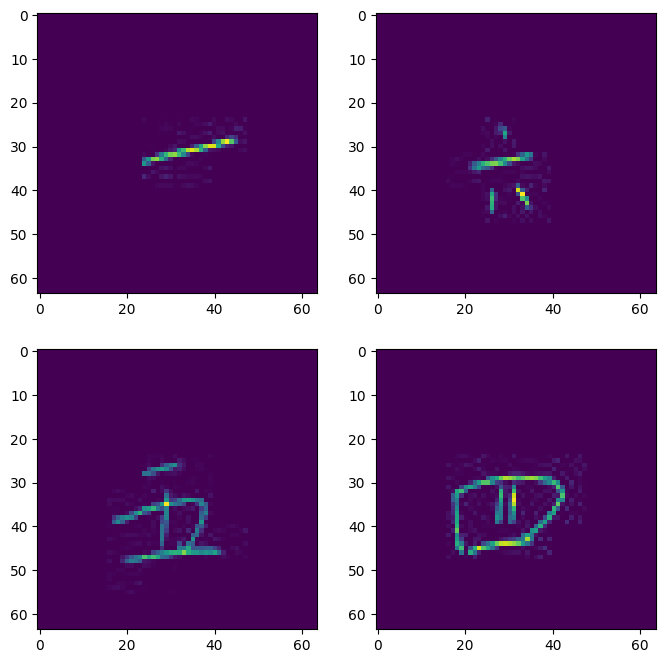

In [92]:
# Randomly select num_images images
random_images = random.sample(images, 4)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))

GRID_SIZE = 2
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        img = random_images[i * GRID_SIZE + j]
        axs[i][j].imshow(img)